<hr style="border: 1px solid black; width: 100%; margin-left: 0">


<div style="text-align:right"> <b>University of Padua - Department of Physics and Astronomy<b> </div> 
<div style="text-align:right"> <strong> Degree course: </strong> Physics of Data</div>
<div style="text-align:right"><strong>Course: </strong>Laboratory of Computational Physics<b> </div>
<div style="text-align:right"><strong>Year: </strong>2023-2024<b> </div>
<div style="text-align:right"><strong>Teacher in charge: </strong>Zanetti Marco<b> </div>
    

#### Students:
- Cucchetto Filippo - 2110510 - filippo.cucchetto.1@studenti.unipd.it
- Simioni Federico      - 2097001 - federico.simioni@studenti.unipd.it
- Amorosetti Gabriel - 2107530 - gabriel.amorosetti@studenti.unipd.it
- Quaglio Emanuele - 2106975 - emanuele.quaglio@studenti.unipd.it
    
<strong>Exam Date</strong>: 21th  of March 2024
    
<center>
    
# Tracking muons with 4 Drift Tubes chambers setup
<center>
<hr style="border: 1px solid black; width: 100%; margin-left: 0">   

# Introduction

# 1. Setting up

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
# Cell dimensions
XCELL = 42.
ZCELL = 13.

# X coordinates translation
global_x_shifts = [994.2, 947.4,-267.4,-261.5,]

# Z coordinates translations
local_z_shifts = [z*ZCELL for z  in range(0,4)]
global_z_shifts = [823.5, 0, 823.5, 0]

''' 
runs identifyed by 
    -folder number 
    -start
    -stop
    -step numbering of files inside of the folder
    -configuration of chambers selected for a given run (chambers are numbered from 0 to 3)
'''

# runs available to our analysis
run260=[260,0,1,1,0,1]
run261=[261,0,1,1,0,1]
run262=[262,0,1,1,0,1]
run331=[331,0,1046,1,0,1,2,3]
run332=[332,29,1289,1,0,1,2,3]
run333=[333,20,1586,5,0,1,2,3]

In [ ]:
#assign to run variable the run you want to analyse
run=run260 #->change this

#creates the file paths
half_path="./180904/Run"+str(run[0]).zfill(6)+"/data_"
start,stop,step=run[1],run[2],run[3]
data_paths=[half_path+str(i).zfill(6)+'.txt' for i in range(start,stop,step)]

#best detectors configuration for a given run ([0,1], [2,3] or [0,1,2,3])
calib_config=list(run[4:])

We import the dataset and store the non-null events in a dictionary `data_dict`, where the keys are `int` numbers indentifying each event, and the values associated are `pandas.DataFrame` objects storing the coordinates of all the event hits.

In [85]:
data_dict={}
false_events_counter=0
for data_path in data_paths:
    with open(data_path) as data_file:
        for line in data_file:
            row=line.strip().split()
            key=int(row[0])
            n_hits=int(row[1])
            if n_hits!=0:
                data_array=np.array(row[2:]).reshape((n_hits, 5))
                event_dict={}
                columns=['chamber', 'layer', 'xleft', 'xright', 'time']
                for i in range(2):
                    event_dict[columns[i]]=data_array[:, i].astype(int)
                for i in range(2,5):
                    event_dict[columns[i]]=data_array[:, i].astype(float)
                value=pd.DataFrame(event_dict)
                data_dict[key]=value
            else:
                false_events_counter+=1
original_data_length=len(data_dict)+false_events_counter
print(f'The total number of events in the original datatset is: {original_data_length}')
print(f"The percentage of the null events (events with 0 hits) w.r.t. the original amount of events is: {false_events_counter/(len(data_dict)+false_events_counter)*100}%")

The total number of events in the original datatset is: 8182
The percentage of the null events (events with 0 hits) w.r.t. the original amount of events is: 40.931312637496944%


We add additional columns to each event `DataFrame` in order to store the global coordinates of the particle hits in a common reference frame for all the detector chambers:
* `'xrg'` labels the global $x$-coordinate (of a hit) located on the right of the wire at the center of the respective cell;
* `'xlg'` labels the global $x$-coordinate (of a hit) located on the left of the wire;
* `'zg'` labels the global $z$-coordinate of the wire;
* `'center'` labels the global $x$-coordinate of the wire;
* `'valid_hit'` is a column of `bool` values that can be modified to store the information of the validity of each hit according to multiple requirements.


In [ ]:
for event in data_dict.values():
    event['xrg']=event.apply(lambda df: global_x_shifts[int(df['chamber'])]-df['xleft'], axis=1)
    event['xlg']=event.apply(lambda df: global_x_shifts[int(df['chamber'])]-df['xright'], axis=1)
    event['zg']=event.apply(lambda df: global_z_shifts[int(df['chamber'])]-local_z_shifts[int(df['layer'])-1]+4*ZCELL-ZCELL/2, axis=1)
    event['center']=(event['xlg']+event['xrg'])/2
    event['valid_hit']=pd.Series(np.ones(len(event)).astype(bool))

In [ ]:
fig, ax=plt.subplots()
count=0
for event in data_dict.values():
    ax.scatter(event['xlg'], event['zg'], color='blue', alpha=0.2)
    ax.scatter(event['xrg'], event['zg'], color='red', alpha=0.2)
    ax.plot((event.groupby('chamber').mean().reset_index()['xlg']+event.groupby('chamber').mean().reset_index()['xlg'])/2, event.groupby('chamber').mean().reset_index()['zg'], '-')
    count+=1
    if(count>=100):
        break
#ax.set_xlim(-450, -405)
plt.show()

Below we plot the distribution of the hits of the considered run on the $xz$ plane. Dots corresponding to hits belonging to the same event are the same color. Only the `xrg` coordinate is considered.

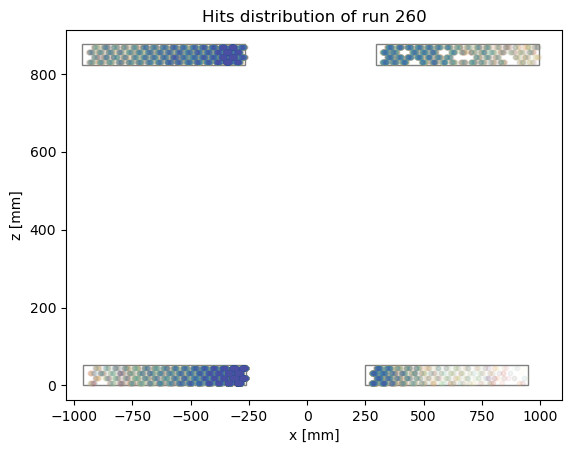

In [84]:
from matplotlib.patches import Rectangle
fig, ax=plt.subplots()
'hits of the same event have the same color, only the `xrg` coordinate is considered'
ax.set_title(f'Hits distribution of run {run[0]}')
ax.set_xlabel('x [mm]')
ax.set_ylabel('z [mm]')
#drawing the detectors   
for i in range(4):
    x_origs=np.array(global_x_shifts)-700
    z_origs=global_z_shifts
    detector=Rectangle([x_origs[i], z_origs[i]], 700, 4*ZCELL, edgecolor='gray', facecolor='white')
    ax.add_artist(detector)
count=0
max_event_number=max(data_dict.keys())
min_event_number=min(data_dict.keys())
for event_item in data_dict.items():
    event_number=event_item[0]
    event=event_item[1]
    ax.scatter(event['xrg'], event['zg'], color=plt.cm.Spectral(plt.Normalize(vmin=min_event_number, vmax=max_event_number)(event_number)), alpha=0.05, s=10)
    #ax.scatter(event['xrg'], event['zg'], color='red', alpha=0.2)
    #ax.plot((event.groupby('chamber').mean().reset_index()['xlg']+event.groupby('chamber').mean().reset_index()['xlg'])/2, event.groupby('chamber').mean().reset_index()['zg'], '-')
    count+=1
    #if(count>=100):
    #    break
    '''
    for hit in event:
        cells(center(hit))+=1
    '''
#ax.set_xlim(-450, -405)

plt.show()

As it is expected for the calibration runs, we observe a higher density of hits on a particular subset of the chambers. To confirm quantitatively such behaviour, below we plot the histogram showing the detectors involved in each event:

In [ ]:
fig,ax=plt.subplots(figsize=(12,7))
bins, counts=(np.unique([str(sorted(np.unique(event['chamber']))) for event in data_dict.values()], return_counts=True))
zipped=zip(counts, bins)
sortedzipped=sorted(zipped, reverse=True)
#print(sortedzipped)
[counts, bins]=zip(*sortedzipped)
#print(bins, counts)
ax.bar(bins, counts, edgecolor='black')
fig.tight_layout()
ax.set_xlabel('detectors involved')
ax.set_ylabel('number of events')
ax.set_title('Number of events for any combination of triggered chambers')

In [ ]:
n_hits_per_event=[len(event) for event in data_dict.values()]
print(f'average n_hits per event: {np.mean(n_hits_per_event)}')
print(f' most frequent n_hits per event {np.unique(n_hits_per_event)[np.argmax(np.unique(n_hits_per_event, return_counts=True)[1])]}')
plt.hist(n_hits_per_event, bins=(max(n_hits_per_event)-min(n_hits_per_event)), edgecolor='gray', )
#plt.hist(n_hits_per_event, edgecolor='gray')
print()
plt.xlabel('number of hits')
plt.ylabel('number of events')
plt.title(f'number of events vs number of hits for the {calib_config} chambers events')

In [ ]:
n_hits_per_event=[len(event) for event in data_dict.values() if sorted(np.unique(event['chamber']))==calib_config]
print(f'average n_hits per event: {np.mean(n_hits_per_event)}')
print(f' most frequent n_hits per event {np.unique(n_hits_per_event)[np.argmax(np.unique(n_hits_per_event, return_counts=True)[1])]}')
plt.hist(n_hits_per_event, bins=(max(n_hits_per_event)-min(n_hits_per_event)), edgecolor='gray')
#plt.hist(n_hits_per_event, edgecolor='gray')
print()
plt.xlabel('number of hits')
plt.ylabel('number of events')
plt.title(f'number of events vs number of hits for the {calib_config} chambers events')

In [ ]:
'''
print(not np.any(np.array(data_dict[4].groupby('chamber').count().reset_index()['layer']<3)))
print(data_dict[4])
'''

In [ ]:
print(list((np.abs(event['xleft']-event['xright'])>XCELL).index))
print(data_dict[1].index)

# 2. Reconstruction on calibration run

In [ ]:
#filters for event selection

def desired_chamber_config(event):
    '''
    print('DCC event: ',event[event['valid_hit']==True])
    print('DCC chamber col', event[event['valid_hit']==True]['chamber'])
    print('DCC config', sorted(np.unique(event[event['valid_hit']==True]['chamber'])))
    '''
    return sorted(np.unique(event['chamber']))==calib_config

def desired_chamber_config_only_valids(event):
    return sorted(np.unique(event[event['valid_hit']==True]['chamber']))==calib_config

def at_least_three_layers_per_det(event):
    return not np.any(event[event['valid_hit']==True].groupby('chamber')['layer'].nunique().reset_index()['layer']<3) and desired_chamber_config_only_valids(event)

def one_hit_per_layer(event):
    return not np.any(event.groupby(['chamber', 'layer']).count().reset_index()['time']!=1)

def max_two_hits_per_layer(event):
    return not np.any(event.groupby(['chamber', 'layer']).count().reset_index()['time']>2)

def max_two_layers_with_more_than_one_hit(event):
    return not np.count_nonzero(event.groupby(['chamber', 'layer']).count().reset_index()['time']>1)>2

    '''
    print('1', np.array(event['valid_hit']==True))
    print('2', np.array(event[event['valid_hit']==True].groupby('chamber')['layer']))
    print('3', event[event['valid_hit']==True].groupby('chamber')['layer'].value_counts().reset_index())
    print('4', np.array(event[event['valid_hit']==True].groupby('chamber')['layer'].value_counts().reset_index()))
    print('5', np.array(event[event['valid_hit']==True].groupby('chamber')['layer'].reset_index()).unique(return_counts=True)[1])
    print('6', np.array(event[event['valid_hit']==True].groupby('chamber')['layer'].reset_index()).unique(return_counts=True)[1]>1)
    print('7', (np.array(event[event['valid_hit']==True].groupby('chamber')['layer'].reset_index()).unique(return_counts=True)[1]>1).count()<=2)
    return (np.array(event[event['valid_hit']==True].groupby('chamber')['layer'].reset_index()).unique(return_counts=True)[1]>1).count()<=2
    '''

#filters for (bad) hit selection

def coordinates_outside_cell(event):
    return list(event[np.abs(event['xleft']-event['xright'])>XCELL].index)

def deviant_hit(event): 
    n_sigmas_treshhold=2
    bad_indices=[]
    def other_hits_mu_std(out_index, event):
        index=list(event[event['chamber']==event.loc[out_index]['chamber']].index)
        index.remove(out_index)
        print('index', index)
        return event.loc[index]['center'].mean(), event.loc[index]['center'].std() 
        
    for out_index, row in event.iterrows():
        print('out_index', out_index)
        mu, std=other_hits_mu_std(out_index, event)
        print(row['center'], mu, abs(row['center']-mu), n_sigmas_treshhold*std, XCELL)
        if abs(row['center']-mu)> max(n_sigmas_treshhold*std, XCELL):
            bad_indices.append(out_index)
    return bad_indices

#filter applicators:

def event_filter(keys_list, e_filter): #modifies the list of keys
    return list(filter(lambda key : e_filter(data_dict[key]), keys_list))

def hit_filter(keys_list, h_filter): #modifies in place the 'valid_hit' column of dataset
    for key in keys_list:
        event=data_dict[key]
        #the "bad" filters return lists of "bad" hit indices, to be set to false. So the lists can just be concatenate with "+"
        bad_rows_indices_list=h_filter(event)
        print('badrowsindes: ',key, bad_rows_indices_list)
        #print('before:', event)
        event.loc[bad_rows_indices_list,'valid_hit'] = False
        #print('after:', event)


In [ ]:
#FILTERS APPLICATION (both event_filters and hit_filters):
#NB: THE ORDER MATTERS!
impeccable_events=event_filter(data_dict, desired_chamber_config)
impeccable_events=event_filter(impeccable_events, max_two_layers_with_more_than_one_hit)
print(f"ratio between impeccable events and nonzerohit events {len(impeccable_events)/len(data_dict)}\n", f"ratio between impeccable events and original dataset events {len(impeccable_events)/original_data_length}")
hit_filter(impeccable_events, coordinates_outside_cell)
print(f"ratio between impeccable events and nonzerohit events {len(impeccable_events)/len(data_dict)}\n", f"ratio between impeccable events and original dataset events {len(impeccable_events)/original_data_length}")
hit_filter(impeccable_events, deviant_hit)
print(f"ratio between impeccable events and nonzerohit events {len(impeccable_events)/len(data_dict)}\n", f"ratio between impeccable events and original dataset events {len(impeccable_events)/original_data_length}")
impeccable_events=event_filter(impeccable_events, at_least_three_layers_per_det)
#impeccable_events=event_filter(data_dict, desired_chamber_config)

print(impeccable_events)
print(len(impeccable_events))
print(f"ratio between impeccable events and nonzerohit events {len(impeccable_events)/len(data_dict)}\n", f"ratio between impeccable events and original dataset events {len(impeccable_events)/original_data_length}")

In [ ]:

event=data_dict[4944]
#print( 'mu std', event.loc[[7,8,9]]['center'].mean(), event.loc[[7,8,9]]['center'].std() )
print(event)
print()
hit_filter([4944], coordinates_outside_cell)
#event_plotter(2)
print(coordinates_outside_cell(event))
print(event)
print('!!!', max_two_layers_with_more_than_one_hit(event))

In [ ]:

print(data_dict[95]['layer'].unique())
print(data_dict[95])


In [ ]:
from itertools import product
from math import atan2
from scipy.stats import linregress


def angle(A,B, C=None):
    #takes two points A and B with coordinates A=(xA,yA)... and return the angle on the plane in radiants
    #OR takes three points A, B, C with coordinates A=(xA,yA).. and return the difference angle BC^-AB^
    if C==None:
        return np.pi/2-atan2(A[1]-B[1], A[0]-B[0])
    else:
        difference=np.abs(angle(B,C)-angle(A,B))
        return min(2*np.pi-difference, difference)

def zigzaginess(path):
    try:
        if(len(path)>=3):
            squaresum=0
            for i in range(len(path)-2):
                A=path[i]
                B=path[i+1]
                C=path[i+2]
                squaresum+=(angle(B,C)-angle(A,B))**2
            return squaresum
        else:
            raise Exception("Error: path of less than 3 points")
    except Exception as err:
        print(err)
    
def tangent_zigzaginess(path):
    try:
        if(len(path)>=3):

            deviation_sum=0
            length_sum=0

            for i in range(len(path)-2):
                A=path[i]
                B=path[i+1]
                C=path[i+2]
                deviation_sum+=(atan2(B[0]-C[0], B[1]-C[1])-atan2(A[0]-B[0], A[1]-B[1]))**2
            deviation_weight=0

            for i in range(len(path)-1):
                A=path[i]
                B=path[i+1]
                length_sum+=(B[0]-A[0])**2+(B[1]-A[1])**2
            length_weight=1

            A,B,C,D=path[0], path[1], path[-2], path[-1]
            first_last_deviation=(atan2(C[0]-D[0], C[1]-D[1])-atan2(A[0]-B[0], A[1]-B[1]))**2
            fldev_weight=1

            return deviation_weight*deviation_sum+fldev_weight*first_last_deviation+length_weight*length_sum
        else:
            raise Exception("Error: path of less than 3 points")
    except Exception as err:
        print(err)

def mse(path):
    x,z=zip(*path)
    res=linregress(z,x)
    sum=0
    for i in range(len(x)):
        sum+=(x[i]-(res.slope*z[i]+res.intercept))**2
    return sum/len(x)

def mse_plus_verticality_compatibility(path):
    x,z=zip(*path)
    res=linregress(z,x)
    sum=0
    for i in range(len(x)):
        sum+=(x[i]-(res.slope*z[i]+res.intercept))**2
    verticality_weight=0
    return sum/len(x)+verticality_weight*(res.slope)**2 #res.slope is prop to comp_index between fit slope and average global (vertical fit)

def opt_track(event, chamber):
    valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]
    valid_subevent=valid_subevent.sort_values(by='zg')

    axes=[]
    for layer in np.sort(valid_subevent['layer'].unique()):
        axis=[]
        for index, row in valid_subevent[event['layer']==layer].iterrows():
            for coord in [row['xlg'], row['xrg']]:
                axis.append((coord, row['zg']))
        axes.append(axis)

    #axes=[['xrg', 'xlg']]*len(valid_subevent)
    paths=list(product(*axes))
    
    #paths=[[(np.array(valid_subevent[xc[i]])[i], np.array(valid_subevent['zg'])[i] ) for i in range(len(valid_subevent))] for xc in xcs]
    #sorting_function=(lambda path : abs(pearsonr(*zip(*path)).pvalue))
    #sorting_function=(lambda path : abs(np.corrcoef(*zip(*path))[0,1]))
    #straightness_function=lambda x: -tangent_zigzaginess(x)
    
    straightness_function=lambda x: -mse_plus_verticality_compatibility(x)
    best_path=max(paths, key=straightness_function)
    path_score=straightness_function(best_path)
    return best_path

In [ ]:
from matplotlib.patches import Rectangle
from scipy.stats import linregress

def event_plotter(event_number, plot_ax=None):
    my_event=data_dict[event_number]
    x_centers, z_centers=(my_event['xlg']+my_event['xrg'])/2, my_event['zg']
    if plot_ax==None:
        fig, ax=plt.subplots(figsize=(12,10))
    else:
        ax=plot_ax

    #drawing the detectors   
    for i in range(4):
        x_origs=np.array(global_x_shifts)-700
        z_origs=global_z_shifts
        detector=Rectangle([x_origs[i], z_origs[i]], 700, 4*ZCELL, edgecolor='gray', facecolor='white')
        ax.add_artist(detector)

    #drawing the triggered cells
    for i in range(len(my_event)):
        rect=Rectangle([x_centers[i]-XCELL/2, z_centers[i]-ZCELL/2], XCELL, ZCELL, edgecolor='black', facecolor='white')
        ax.add_artist(rect)

    #drawing the points of hits
    dots_size=int(ax.get_position().width*20)+1
    ax.scatter(my_event['xlg'], my_event['zg'], color='blue', s=dots_size)
    ax.scatter(my_event['xrg'], my_event['zg'], color='red', s=dots_size)
    XRANGE=[-1000, 1000]
    YRANGE=[-100, 950]
    ax.set_xlim(XRANGE)
    ax.set_ylim(YRANGE)
    ax.set_xlabel('x [mm]')
    ax.set_ylabel('z [mm]')
    ax.set_title(f'Event {event_number}', size=16)

    def tracker_fitter(in_line_chambers):
        #print('chamber:', in_line_chambers[0])
        (xu,zu)=zip(*opt_track(my_event, in_line_chambers[0]))
        #print('chamber:', in_line_chambers[1])
        (xd,zd)=zip(*opt_track(my_event, in_line_chambers[1]))
        x=np.concatenate([xu,xd])
        z=np.concatenate([zu,zd])

        resu=linregress(zu,xu)
        resd=linregress(zd,xd)
        res=linregress(z,x)

        xspace=np.linspace(*XRANGE, 1000)
        ax.plot(xspace, 1/resu.slope*xspace-resu.intercept/resu.slope, '--')
        ax.plot(xspace, 1/resd.slope*xspace-resd.intercept/resd.slope, '--')
        ax.plot(xspace, 1/res.slope*xspace-res.intercept/res.slope, color='black')
    
    for i in range(0,len(calib_config),2):
        tracker_fitter(calib_config[i:i+2])

    if plot_ax==None:
        plt.show()

In [ ]:
def event_filter_from_fit(event_number):
    event_is_tricky=False
    my_event=data_dict[event_number]
    x_centers, z_centers=(my_event['xlg']+my_event['xrg'])/2, my_event['zg']

    def tracker_fitter(in_line_chambers):
        is_tricky=False
        #print('chamber:', in_line_chambers[0])
        (xu,zu)=zip(*opt_track(my_event, in_line_chambers[0]))
        #print('chamber:', in_line_chambers[1])
        (xd,zd)=zip(*opt_track(my_event, in_line_chambers[1]))
        x=np.concatenate([xu,xd])
        z=np.concatenate([zu,zd])

        resu=linregress(zu,xu)
        resd=linregress(zd,xd)
        res=linregress(z,x)

        #criteria for trickyness 
        def angle_criterium(xu,zu,xd,zd,resu,resd,res):
            angle_tresh=np.pi/4
            return abs(np.arctan(resu.slope)-np.arctan(res.slope))>angle_tresh or abs(np.arctan(resd.slope)-np.arctan(res.slope))>angle_tresh
        
        def fit_compatibility_criterium(xu,zu,xd,zd,resu,resd,res):
            comp_index_tresh=3
            comp_index='...'
            return comp_index>comp_index_tresh
        


        #if abs(resu.slope)>ang_coef_tresh or abs(resd.slope)>ang_coef_tresh: event_is_tricky=True
        if angle_criterium(xu,zu,xd,zd,resu,resd,res): is_tricky=True
        #ax.plot(xu,zu)
        #ax.plot(xd,zd)
        return is_tricky
    
    for i in range(0,len(calib_config),2):
        is_tricky=tracker_fitter(calib_config[i:i+2])
        if is_tricky: event_is_tricky=True
    #print(event_number)
    #print(my_event)

    return event_number, event_is_tricky

In [ ]:
tricky_events=[]
for event_n in impeccable_events:
    event_number, event_is_tricky=event_filter_from_fit(event_n)
    if event_is_tricky:
        tricky_events.append(event_number)

print('TRICKY EVENTS: ', tricky_events)
print(f'# pre-fit good events: {len(impeccable_events)}')
print(f'# post-fit good events: {len(impeccable_events)-len(tricky_events)}')
print(f'precentage of good events showing good agreements between local and global fit: {(len(impeccable_events)-len(tricky_events))/len(impeccable_events)*100}%')
print(f'precentage of events in original dataset showing good agreements between local and global fit: {(len(impeccable_events)-len(tricky_events))/original_data_length*100}%')

events_to_plot=[item for item in impeccable_events if item not in tricky_events]
n_plots=len(events_to_plot)
n_cols=3
fig,axes=plt.subplots(ncols=n_cols, nrows=n_plots//n_cols+1, figsize=(14,(14/n_cols)*(n_plots//n_cols+1)))
k=0
for ax in axes.reshape(-1):
    if(k<len(events_to_plot)):
        event_plotter(events_to_plot[k], plot_ax=ax)
    else:
        ax.axis('off')
    k+=1
fig.tight_layout()

In [ ]:
print(events_to_plot)

### Let's observe that the eighth hit of 51-th event of first calibration run (so maybe other ones too) not only presents xleft and xright farther apart than the width of a cell, but neither of the two isn't compatible with a fitting line for the trajectory

In [ ]:
#numbers_to_check=[17959]
numbers_to_check=tricky_events
for number_to_check in numbers_to_check:
    print(data_dict[number_to_check])
    print('filter result: ', at_least_three_layers_per_det(data_dict[number_to_check]))
    event_plotter(number_to_check)


In [ ]:
print(events_to_plot)

In [ ]:
previous_events_to_plot=[95, 273, 1487, 6577, 8556, 9523, 9525, 9593, 9775, 10475, 14573, 15810, 17222, 17569, 18635, 22281, 23701, 24070, 25252, 26112, 26629, 27506, 35576, 38174, 39825, 40046, 40407, 43905, 45686, 49274, 49846, 50094, 50958, 51412, 51581, 54198, 54286, 54928, 55290, 55866, 56209, 56242, 56419, 56720, 57149, 58081, 58858, 58933, 59974, 60361]


In [ ]:
print(len(events_to_plot), len(previous_events_to_plot), len([event for event in previous_events_to_plot if event in events_to_plot]))

In [ ]:
print([event for event in events_to_plot if event not in previous_events_to_plot])

In [ ]:
#numbers_to_check=[3237]
numbers_to_check=tricky_events
for number_to_check in numbers_to_check:
    print(data_dict[number_to_check])
    print('filter result: ', at_least_three_layers_per_det(data_dict[number_to_check]))
    event_plotter(number_to_check)


### We reconsider only the tricky events and apply a different path selection algorithm that rewards, on top of the most linear paths, also a better compatibility of the local fit with the assumption that the muon trajectory is likely vertical in the x-z plane. To do that we set the vericality_weight parameter to 10.

In [ ]:
def mse_plus_verticality_compatibility(path):
    x,z=zip(*path)
    res=linregress(z,x)
    sum=0
    for i in range(len(x)):
        sum+=(x[i]-(res.slope*z[i]+res.intercept))**2
    verticality_weight=10
    return sum/len(x)+verticality_weight*(res.slope)**2 #res.slope is prop to comp_index between fit slope and average global (vertical fit)

still_tricky_events=[]
for event_n in impeccable_events:
    event_number, event_is_tricky=event_filter_from_fit(event_n)
    if event_is_tricky:
        still_tricky_events.append(event_number)

print('STILL TRICKY EVENTS: ', still_tricky_events)
print(f'# pre-fit good events: {len(impeccable_events)}')
print(f'# post-fit good events: {len(impeccable_events)-len(still_tricky_events)}')
print(f'precentage of good events showing good agreements between local and global fit: {(len(impeccable_events)-len(still_tricky_events))/len(impeccable_events)*100}%')
print(f'precentage of events in original dataset showing good agreements between local and global fit: {(len(impeccable_events)-len(still_tricky_events))/original_data_length*100}%')

events_to_plot=[item for item in tricky_events if item not in still_tricky_events]
n_plots=len(events_to_plot)
n_cols=3
fig,axes=plt.subplots(ncols=n_cols, nrows=n_plots//n_cols+1, figsize=(14,(14/n_cols)*(n_plots//n_cols+1)))
k=0
for ax in axes.reshape(-1):
    if(k<len(events_to_plot)):
        event_plotter(events_to_plot[k], plot_ax=ax)
    else:
        ax.axis('off')
    k+=1
fig.tight_layout()

# 3. Reconstruction on physics runs